In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

In [2]:
# read all of the data
# https://github.com/mttk/STL10
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show_images(data,row=1,col=1):
    fig=plt.figure(figsize=(10,10))
    columns = col; rows = row
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
    plt.show()

train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [3]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=4,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        
    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return self.layer,self.layerA
    
    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        
        return grad_pass,grad,update_w
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
    
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
  
class tf_box_cox():
    
    def __init__(self):
        self.lmbda    = tf.Variable(2.0) 
        self.m,self.v = tf.Variable(tf.zeros_like(self.lmbda)),tf.Variable(tf.zeros_like(self.lmbda))
    def getw(self): return self.lmbda
    
    def feedforward(self,data):
        self.input = data
        self.layer = tf.pow((self.input + 1.0),self.lmbda)
        return (self.layer - 1.0)/(self.lmbda + 1e-8)
    
    def backprop(self,grad):
        
        # Gradient that gets passed along
        grad_pass = tf.pow((self.input + 1),self.lmbda-1.0) * grad
        
        # Grad respect to the lmbda value (not tested!)
        grad_lmbda1 =   (self.layer * tf.log(self.input + 1 ))/(self.lmbda + 1e-8)
        grad_lmbda2 = - (self.layer - 1)/(self.lmbda ** 2 + 1e-8)
        grad_lmbda  = tf.reduce_mean((grad_lmbda1 + grad_lmbda2)*grad)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad_lmbda)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad_lmbda ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.lmbda,tf.subtract(self.lmbda,adam_middle  )))
        
        return grad_pass,grad_lmbda,update_w

In [17]:
# set hyper parameter
sess.close()
num_epoch = 200; learning_rate = 0.0008; batch_size = 50; beta1,beta2,adam_e = 0.9,0.999,1e-9

C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Current Iter : 0/200 batch : 7950/8000 acc : 0.14
 Current : 0 Acc : 0.11999999955296517 Test Acc : 0.12849999975878745

Current Iter : 1/200 batch : 7950/8000 acc : 0.18
 Current : 1 Acc : 0.19639999967068433 Test Acc : 0.232624999480322



KeyboardInterrupt: 

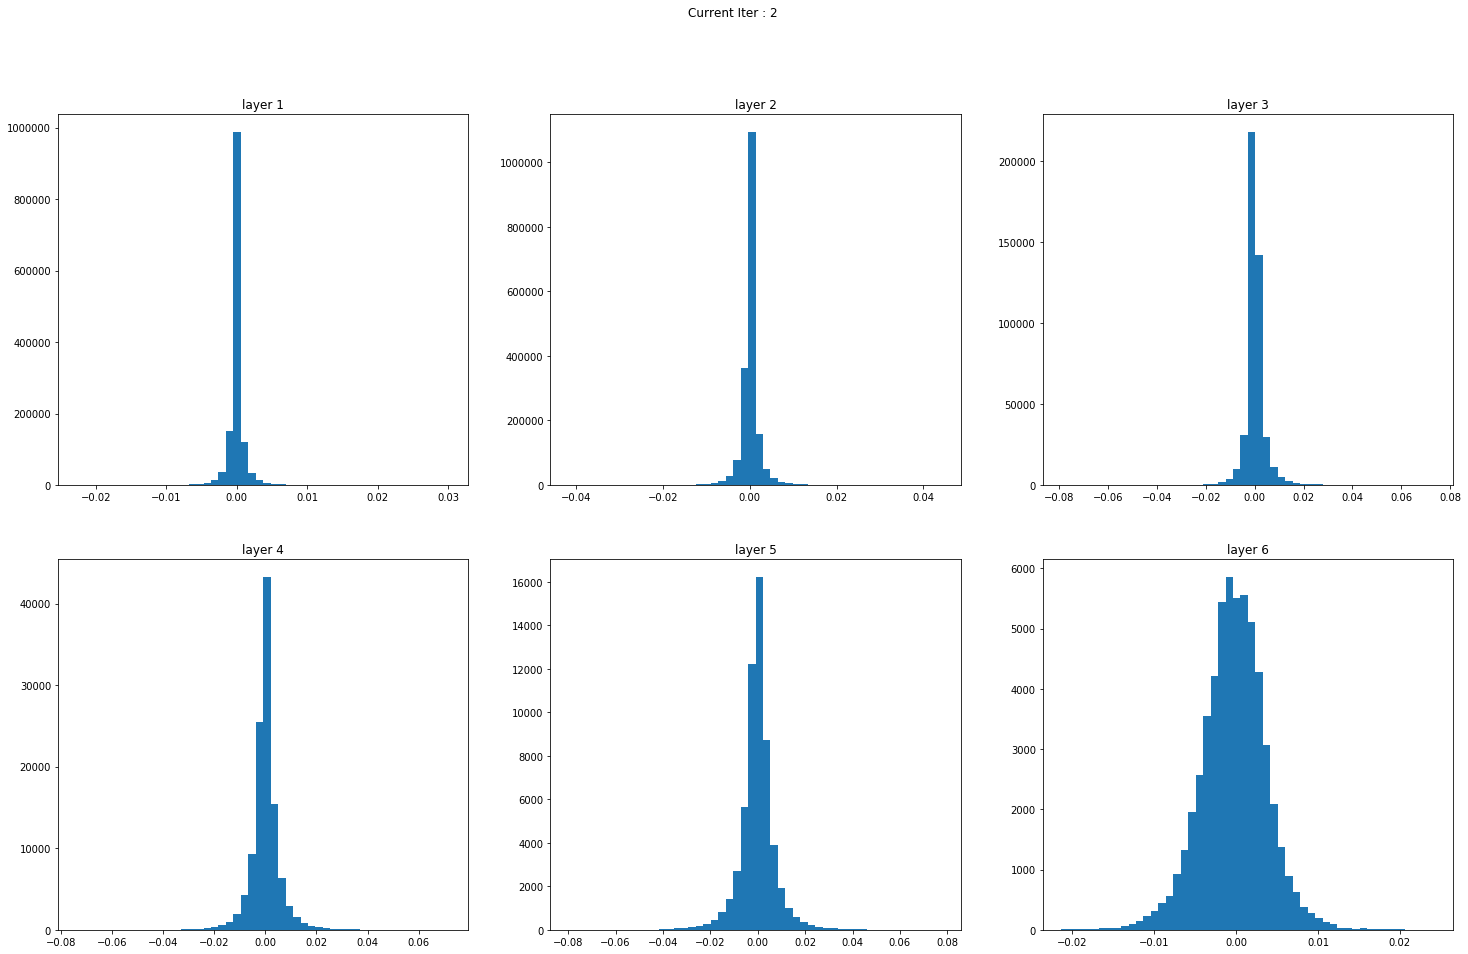

In [16]:
# 1. Normal CNN 
sess = tf.InteractiveSession()

# create layers
l1 = CNN(3,3, 16); 
l2 = CNN(3,16,16); 
l3 = CNN(3,16,16); 

l4 = CNN(3,16,32); 
l5 = CNN(3,32,32); 
l6 = CNN(3,32,10); 

# create the graph 
x = tf.placeholder(tf.float32,[batch_size,96,96,3])
y = tf.placeholder(tf.float32,[batch_size,10])

layer1,layer1a = l1.feedforward(x,stride=2)      ;          
layer2,layer2a = l2.feedforward(layer1a,stride=2);         
layer3,layer3a = l3.feedforward(layer2a,stride=2); 

layer4,layer4a = l4.feedforward(layer3a,stride=2);          
layer5,layer5a = l5.feedforward(layer4a,stride=1);         
layer6,layer6a = l6.feedforward(layer5a,stride=1); 

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up = l6.backprop(gradient)
grad5p,grad5w,grad5_up = l5.backprop(grad6p)
grad4p,grad4w,grad4_up = l4.backprop(grad5p,stride=2)

grad3p,grad3w,grad3_up = l3.backprop(grad4p,stride=2)
grad2p,grad2w,grad2_up = l2.backprop(grad3p,stride=2)
grad1p,grad1w,grad1_up = l1.backprop(grad2p,stride=2)

gradient_update = grad6_up + grad5_up + grad4_up + grad3_up + grad2_up + grad1_up 

# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
normal_train_acc = [];normal_test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    # Get weights
    l1w,l2w,l3w,l4w,l5w,l6w = sess.run([l1.getw(),l2.getw(),l3.getw(),l4.getw(),l5.getw(),l6.getw()])
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1w.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2w.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3w.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4w.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5w.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6w.ravel(),50); plt.title('layer 6')
    plt.savefig('Normal/weights/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')    
    
    # Get gradients
    l1g,l2g,l3g,l4g,l5g,l6g = sess.run([grad1w,grad2w,grad3w,grad4w,grad5w,grad6w],feed_dict={x:current_data,y:current_label})
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig('Normal/gradientw/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')            
        
    # Get gradients pass
    l1g,l2g,l3g,l4g,l5g,l6g = sess.run([grad1p,grad2p,grad3p,grad4p,grad5p,grad6p],feed_dict={x:current_data,y:current_label})
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig('Normal/gradientp/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')    
    
    # Get gradients update
    l1g,l2g,l3g,l4g,l5g,l6g = sess.run([grad1_up,grad2_up,grad3_up,grad4_up,grad5_up,grad6_up],feed_dict={x:current_data,y:current_label})
    l1g,l2g,l3g,l4g,l5g,l6g = np.asarray(l1g),np.asarray(l2g),np.asarray(l3g),np.asarray(l4g),np.asarray(l5g),np.asarray(l6g)
    plt.figure(figsize=(25,15))
    plt.suptitle('Current Iter : ' + str(iter))
    plt.subplot(231); plt.hist(l1g.ravel(),50); plt.title('layer 1')
    plt.subplot(232); plt.hist(l2g.ravel(),50); plt.title('layer 2')
    plt.subplot(233); plt.hist(l3g.ravel(),50); plt.title('layer 3')
    plt.subplot(234); plt.hist(l4g.ravel(),50); plt.title('layer 4')
    plt.subplot(235); plt.hist(l5g.ravel(),50); plt.title('layer 5')
    plt.subplot(236); plt.hist(l6g.ravel(),50); plt.title('layer 6')
    plt.savefig('Normal/gradient_update/' + str(iter)+'.png')
    plt.tight_layout()
    plt.close('all')  
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    normal_train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    normal_test_acc .append(avg_acc_test / (len(test_images)/batch_size))
    avg_acc_train = 0 ; avg_acc_test  = 0
    
sess.close()
tf.reset_default_graph();

In [60]:
# create layers
num_epoch = 150; learning_rate = 0.001; batch_size = 100
beta1,beta2,adam_e = 0.9,0.999,1e-8
sess = tf.InteractiveSession()
l1 = CNN(3,3, 16); l1n = tf_box_cox()
l2 = CNN(3,16,16); l2n = tf_box_cox()
l3 = CNN(3,16,16); l3n = tf_box_cox()

l4 = CNN(3,16,32); l4n = tf_box_cox()
l5 = CNN(3,32,32); l5n = tf_box_cox()
l6 = CNN(3,32,10); 

In [61]:
# create the graph 
x = tf.placeholder(tf.float32,[batch_size,96,96,3])
y = tf.placeholder(tf.float32,[batch_size,10])

layer1,layer1a = l1.feedforward(x,stride=2)      ;          
layer1n = l1n.feedforward(layer1a)
layer2,layer2a = l2.feedforward(layer1n,stride=2);          
layer2n = l2n.feedforward(layer2a)
layer3,layer3a = l3.feedforward(layer2n,stride=2); 
layer3n = l3n.feedforward(layer3a)

layer4,layer4a = l4.feedforward(layer3n,stride=2);          
layer4n = l4n.feedforward(layer4a)
layer5,layer5a = l5.feedforward(layer4n,stride=1);          
layer5n = l5n.feedforward(layer5a)
layer6,layer6a = l6.feedforward(layer5n,stride=1); 

final_layer   = tf.reduce_mean(layer6a,(1,2))
final_softmax = tf_softmax(final_layer)
cost          = -tf.reduce_mean(y * tf.log(final_softmax + 1e-8))
auto_train = tf.train.AdamOptimizer(learning_rate).minimize(cost)
correct_prediction = tf.equal(tf.argmax(final_softmax, 1), tf.argmax(y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gradient = tf.tile((final_softmax-y)[:,None,None,:],[1,6,6,1])/batch_size
grad6p,grad6w,grad6_up  = l6.backprop(gradient)
grad5n,grad5l,grad5n_up = l5n.backprop(grad6p); 
grad5p,grad5w,grad5_up  = l5.backprop(grad5n,stride=1)
grad4n,grad4l,grad4n_up = l4n.backprop(grad5p); 
grad4p,grad4w,grad4_up  = l4.backprop(grad4n,stride=2)

grad3n,grad3l,grad3n_up = l3n.backprop(grad4p);
grad3p,grad3w,grad3_up  = l3.backprop(grad3n,stride=2)
grad2n,grad2l,grad2n_up = l2n.backprop(grad3p); 
grad2p,grad2w,grad2_up  = l2.backprop(grad2n,stride=2)
grad1n,grad1l,grad1n_up = l1n.backprop(grad2p); 
grad1p,grad1w,grad1_up  = l1.backprop(grad1n,stride=2)

gradient_update = grad6_up + \
                  grad5n_up + grad5_up + \
                  grad4n_up + grad4_up + \
                  grad3n_up + grad3_up + \
                  grad2n_up + grad2_up + \
                  grad1n_up + grad1_up 

In [62]:
# train
sess.run(tf.global_variables_initializer())
avg_acc_train = 0; avg_acc_test  = 0; 
train_acc     = [];test_acc = []
for iter in range(num_epoch):

    for current_batch_index in range(0,len(train_images),batch_size):
        current_data  = train_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = train_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,gradient_update],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]
        
    for current_batch_index in range(0,len(test_images), batch_size):
        current_data  = test_images[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = test_labels[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy],feed_dict={x:current_data,y:current_label})
        sys.stdout.write('Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0]   
        
    print("\n Current : "+ str(iter) + " Acc : " + str(avg_acc_train/(len(train_images)/batch_size)) + " Test Acc : " + str(avg_acc_test/(len(test_images)/batch_size)) + '\n')
    
    # save the training
    train_acc.append(avg_acc_train/(len(train_images)/batch_size))
    test_acc .append(avg_acc_test/(len(test_images)/batch_size)  )
    
    avg_acc_train = 0 ; avg_acc_test  = 0


Current Iter : 0/150 batch : 7900/8000 acc : 0.15
 Current : 0 Acc : 0.10639999989420175 Test Acc : 0.12137499949894845

Current Iter : 1/150 batch : 7900/8000 acc : 0.21
 Current : 1 Acc : 0.11419999979436397 Test Acc : 0.14175000037066637

Current Iter : 2/150 batch : 7900/8000 acc : 0.14
 Current : 2 Acc : 0.11979999981820583 Test Acc : 0.10049999975599348

Current Iter : 3/150 batch : 7900/8000 acc : 0.14
 Current : 3 Acc : 0.11179999962449073 Test Acc : 0.09999999976716936

Current Iter : 4/150 batch : 7900/8000 acc : 0.11
 Current : 4 Acc : 0.12080000028014183 Test Acc : 0.12437499961815775

Current Iter : 5/150 batch : 7900/8000 acc : 0.12
 Current : 5 Acc : 0.15379999995231627 Test Acc : 0.158500000461936

Current Iter : 6/150 batch : 7900/8000 acc : 0.16
 Current : 6 Acc : 0.17820000007748604 Test Acc : 0.1642500003799796

Current Iter : 7/150 batch : 7900/8000 acc : 0.25
 Current : 7 Acc : 0.2115999987721443 Test Acc : 0.21212499951943756

Current Iter : 8/150 batch : 7900/80

Current Iter : 67/150 batch : 7900/8000 acc : 0.46
 Current : 67 Acc : 0.5201999932527542 Test Acc : 0.4617499984800816

Current Iter : 68/150 batch : 7900/8000 acc : 0.51
 Current : 68 Acc : 0.5215999972820282 Test Acc : 0.4598749980330467

Current Iter : 69/150 batch : 7900/8000 acc : 0.47
 Current : 69 Acc : 0.5119999939203262 Test Acc : 0.47162499763071536

Current Iter : 70/150 batch : 7900/8000 acc : 0.53
 Current : 70 Acc : 0.5390000009536743 Test Acc : 0.48337499611079693

Current Iter : 71/150 batch : 7900/8000 acc : 0.47
 Current : 71 Acc : 0.52819999396801 Test Acc : 0.4769999966025352

Current Iter : 72/150 batch : 7900/8000 acc : 0.59
 Current : 72 Acc : 0.5243999963998794 Test Acc : 0.4658749982714653

Current Iter : 73/150 batch : 7900/8000 acc : 0.48
 Current : 73 Acc : 0.5217999970912933 Test Acc : 0.47449999712407587

Current Iter : 74/150 batch : 7900/8000 acc : 0.47
 Current : 74 Acc : 0.5339999961853027 Test Acc : 0.4834999952465296

Current Iter : 75/150 batch : 7

Current Iter : 134/150 batch : 7900/8000 acc : 0.42
 Current : 134 Acc : 0.589400002360344 Test Acc : 0.49337499365210535

Current Iter : 135/150 batch : 7900/8000 acc : 0.51
 Current : 135 Acc : 0.6179999995231629 Test Acc : 0.5069999977946281

Current Iter : 136/150 batch : 7900/8000 acc : 0.47
 Current : 136 Acc : 0.6142000031471252 Test Acc : 0.49812499769032004

Current Iter : 137/150 batch : 7900/8000 acc : 0.48
 Current : 137 Acc : 0.6310000014305115 Test Acc : 0.49799999557435515

Current Iter : 138/150 batch : 7900/8000 acc : 0.49
 Current : 138 Acc : 0.6242000019550323 Test Acc : 0.5007499985396862

Current Iter : 139/150 batch : 7900/8000 acc : 0.47
 Current : 139 Acc : 0.6029999947547913 Test Acc : 0.4994999963790178

Current Iter : 140/150 batch : 7900/8000 acc : 0.45
 Current : 140 Acc : 0.6160000038146972 Test Acc : 0.49149999506771563

Current Iter : 141/150 batch : 7900/8000 acc : 0.48
 Current : 141 Acc : 0.6243999981880188 Test Acc : 0.5137499962002039

Current Iter 

In [15]:
! start .

# Reference
1. mttk/STL10. (2018). GitHub. Retrieved 19 December 2018, from https://github.com/mttk/STL10
2. [duplicate], H. (2018). How to display multiple images in one figure correctly?. Stack Overflow. Retrieved 19 December 2018, from https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly